In [1]:
from typing import Callable, List
from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier


import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/preproc_train_data.csv")

In [3]:
train_data, val_data = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["isFraud"],
)

In [10]:
x_train = train_data.drop(columns=["isFraud"])
y_train = train_data["isFraud"]
x_val = val_data.drop(columns=["isFraud"])
y_val = val_data["isFraud"]

n_train = int(len(x_train) * 0.2)
n_test = int(len(x_val) * 0.2)
        
x_train = x_train.sample(n=n_train, replace=False, random_state=42)
y_train = y_train.sample(n=n_train, replace=False, random_state=42)
x_val = x_val.sample(n=n_test, replace=False, random_state=42)
y_val = y_val.sample(n=n_test, replace=False, random_state=42)    

In [5]:
import catboost

def catboost_fn():
    return catboost.CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=7,
        eval_metric="Accuracy",
        random_seed=42,
        verbose=False,
        task_type="CPU",
        devices="0",
    )

In [6]:
import lightgbm

def lgbm_fn():
    return lightgbm.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42,
        metric="auc",
        verbose=-1,
    )


In [7]:
def tree_fn():
    return DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
    )

In [8]:
from niapy.problems import Problem


class CatBoostProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series    ):

        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        train_pool = catboost.Pool(
            data=self.x_train[features_to_use],
            label=self.y_train        )
        
        val_pool = catboost.Pool(
            data=self.x_val[features_to_use],
            label=self.y_val
        )
        model = self.model_fn()
        model.fit(
            train_pool,
            eval_set=val_pool,
        )

        y_pred = model.predict_proba(self.x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc


class LGBMProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series
    ):
        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        model = self.model_fn()
        model.fit(
            self.x_train[features_to_use],
            self.y_train,
            eval_set=(self.x_val[features_to_use], self.y_val)
        )

        y_pred = model.predict_proba(self.x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc


class TreeProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series    ):

        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        x_train = self.x_train.copy()
        x_val = self.x_val.copy()

        model = self.model_fn()

        model.fit(
            x_train[features_to_use],
            self.y_train,
        )

        y_pred = model.predict_proba(x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc

In [11]:
from niapy.task import Task
from niapy.algorithms.basic import (
    ParticleSwarmAlgorithm,
    GreyWolfOptimizer,
    FireflyAlgorithm,
    CuckooSearch,
    FlowerPollinationAlgorithm,
    BatAlgorithm,
    ArtificialBeeColonyAlgorithm,
)

algos = [
    ParticleSwarmAlgorithm,
    GreyWolfOptimizer,
    FireflyAlgorithm,
    CuckooSearch,
    FlowerPollinationAlgorithm,
    BatAlgorithm,
    ArtificialBeeColonyAlgorithm,
]

problems = {
    "catboost": CatBoostProblem(
        model_fn=catboost_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val
    ),
    "lgbm": LGBMProblem(
        model_fn=lgbm_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val
    ),
    "tree": TreeProblem(
        model_fn=tree_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val
    )
}

In [12]:
def evaluate_algorithm(
    problem: Problem,
    algo_fn: Callable,
    max_iters: int = 10,
    max_evals: int = 10,
    population_size: int = 10,
    n_init: int = 5,
):
    best_x = None
    best_y = float("inf")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        task = Task(problem=problem, max_iters=max_iters, max_evals=max_evals)
        algo = algo_fn(population_size=population_size)
        x, y = algo.run(task)

        if y < best_y:
            best_y = y
            best_x = x

        print(f"Current result: {-y}, Best: {-best_y}")

    return best_x, -best_y


In [13]:
results = []

for name, problem in problems.items():
    for algo in algos:
        print(f"Running {name} with {algo.__name__}")
        best_x, best_y = evaluate_algorithm(
            problem=problem,
            algo_fn=algo,
            max_iters=50,
            max_evals=50,
            population_size=10,
            n_init=2,
        )
        results.append(
            {
                "model": name,
                "algorithm": algo.__name__,
                "score": best_y,
                "features": best_x,
            }
        )
        print(f"Best AUC: {best_y}")

Running catboost with ParticleSwarmAlgorithm
Initialization 1/2
Current result: 0.8882457289960695, Best: 0.8882457289960695
Initialization 2/2
Current result: 0.8908433378626236, Best: 0.8908433378626236
Best AUC: 0.8908433378626236
Running catboost with GreyWolfOptimizer
Initialization 1/2
Current result: 0.8855255179882865, Best: 0.8855255179882865
Initialization 2/2
Current result: 0.8896409459713945, Best: 0.8896409459713945
Best AUC: 0.8896409459713945
Running catboost with FireflyAlgorithm
Initialization 1/2
Current result: 0.8868643364425994, Best: 0.8868643364425994
Initialization 2/2
Current result: 0.8863985814299921, Best: 0.8868643364425994
Best AUC: 0.8868643364425994
Running catboost with CuckooSearch
Initialization 1/2
Current result: 0.8875930882806075, Best: 0.8875930882806075
Initialization 2/2
Current result: 0.8865650377094387, Best: 0.8875930882806075
Best AUC: 0.8875930882806075
Running catboost with FlowerPollinationAlgorithm
Initialization 1/2
Current result: 0

In [14]:
results = [[entry["model"]] + [entry["algorithm"]] + [entry["score"]] for entry in results]
results = pd.DataFrame(
    results,
    columns=["model", "algorithm", "score"]
)


In [17]:
results

,model,algorithm,score
0,catboost,ParticleSwarmAlgorithm,0.890843
1,catboost,GreyWolfOptimizer,0.889641
2,catboost,FireflyAlgorithm,0.886864
3,catboost,CuckooSearch,0.887593
4,catboost,FlowerPollinationAlgorithm,0.887176
5,catboost,BatAlgorithm,0.888699
6,catboost,ArtificialBeeColonyAlgorithm,0.884934
7,lgbm,ParticleSwarmAlgorithm,0.913650
8,lgbm,GreyWolfOptimizer,0.914235
9,lgbm,FireflyAlgorithm,0.910445


In [18]:
train_pool = catboost.Pool(
    data=x_train,
    label=y_train
)
val_pool = catboost.Pool(
    data=x_val,
    label=y_val
)
catboost_model = catboost_fn().fit(
    train_pool,
    eval_set=val_pool,
)
y_pred = catboost_model.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["catboost", "original", auc]],
            columns=["model", "algorithm", "score"],
        ),
    ],
    axis=0,
)

lgbm_model = lgbm_fn().fit(
    x_train,
    y_train,
    eval_set=(x_val, y_val)
)
y_pred = lgbm_model.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["lgbm", "original", auc]],
            columns=["model", "algorithm", "score"],
        ),
    ],
    axis=0,
)

tree_model = tree_fn().fit(
    x_train,
    y_train,
)
y_pred = tree_model.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["tree", "original", auc]],
            columns=["model", "algorithm", "score"],
        ),
    ],
    axis=0,
)


In [19]:
results = results.drop_duplicates()

In [20]:
results

,model,algorithm,score
0,catboost,ParticleSwarmAlgorithm,0.890843
1,catboost,GreyWolfOptimizer,0.889641
2,catboost,FireflyAlgorithm,0.886864
3,catboost,CuckooSearch,0.887593
4,catboost,FlowerPollinationAlgorithm,0.887176
5,catboost,BatAlgorithm,0.888699
6,catboost,ArtificialBeeColonyAlgorithm,0.884934
7,lgbm,ParticleSwarmAlgorithm,0.913650
8,lgbm,GreyWolfOptimizer,0.914235
9,lgbm,FireflyAlgorithm,0.910445


In [21]:
results.to_csv("../data/results.csv", index=False)

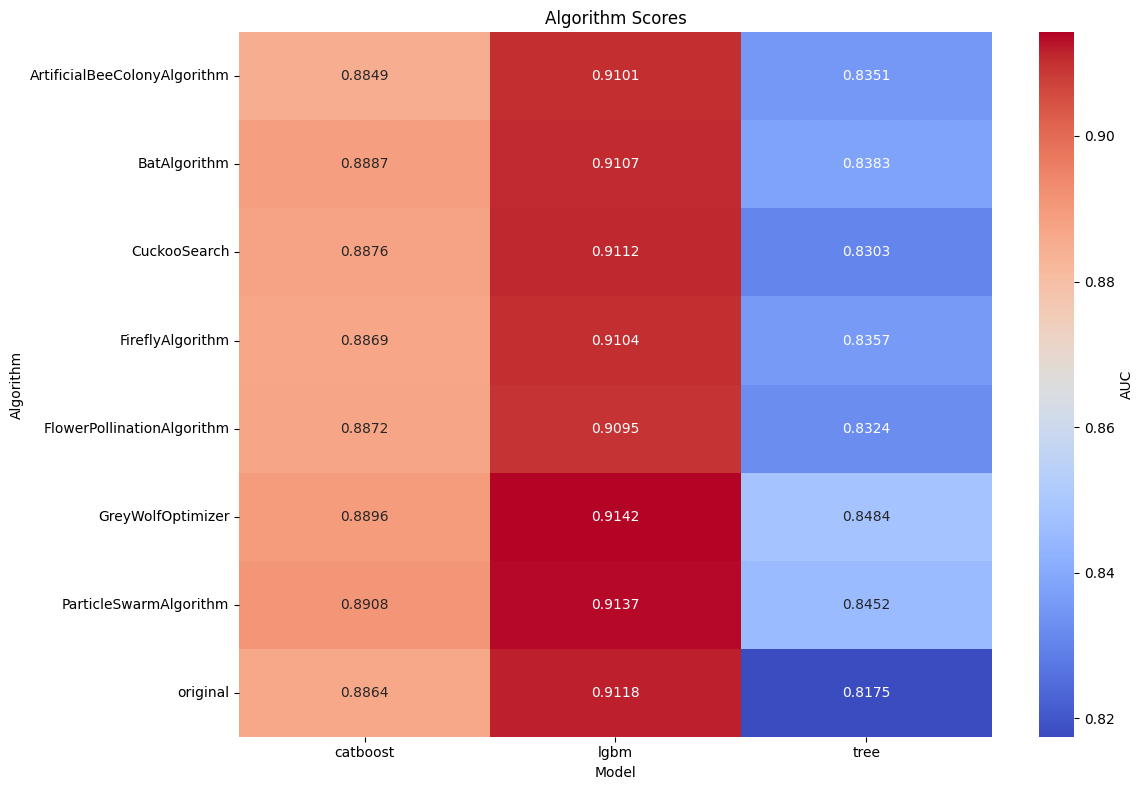

In [22]:
algo_scores = results.pivot_table(index="algorithm", columns="model", values="score")

algo_scores.to_csv("../data/algorithm_scores.csv")

plt.figure(figsize=(12, 8))

sns.heatmap(
    algo_scores,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar_kws={"label": "AUC"},
)
plt.title("Algorithm Scores")
plt.xlabel("Model")
plt.ylabel("Algorithm")
plt.tight_layout()
plt.savefig("algorithm_scores.png")
plt.show()